In [ ]:
!pip install featuretools==0.27.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 327 kB 5.1 MB/s 
     |████████████████████████████████| 596 kB 40.1 MB/s 
     |████████████████████████████████| 281 kB 51.7 MB/s 
     |████████████████████████████████| 837 kB 27.0 MB/s 
     |████████████████████████████████| 140 kB 55.1 MB/s 
     |████████████████████████████████| 830 kB 51.9 MB/s 
     |████████████████████████████████| 822 kB 51.5 MB/s 
     |████████████████████████████████| 802 kB 1.7 MB/s 
     |████████████████████████████████| 802 kB 32.7 MB/s 
     |████████████████████████████████| 793 kB 53.6 MB/s 
     |████████████████████████████████| 793 kB 53.0 MB/s 
     |████████████████████████████████| 791 kB 55.5 MB/s 
     |████████████████████████████████| 786 kB 42.9 MB/s 
     |████████████████████████████████| 779 kB 52.5 MB/s 
     |████████████████████████████████| 778 kB 56.7 MB/s 
     |███████████████████████████

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Feataurestools for feature engineering
import featuretools as ft

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# Importing gradient boosting regressor, to make prediction
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

#importing primitives
from featuretools.primitives import (Minute, Hour, Day, Month,
                                     Weekday, IsWeekend, Count, Sum, Mean, Median, Std, Min, Max)

print(ft.__version__)
%load_ext autoreload
%autoreload 2

0.27.0


In [ ]:
np.random.seed(40)

# To load the dataset
def load_nyc_taxi_data():
    trips = pd.read_csv('trips.csv',
                        parse_dates=["pickup_datetime","dropoff_datetime"],
                        dtype={'vendor_id':"category",'passenger_count':'int64'},
                        encoding='utf-8')
    trips["payment_type"] = trips["payment_type"].apply(str)
    trips = trips.dropna(axis=0, how='any', subset=['trip_duration'])

    pickup_neighborhoods = pd.read_csv("pickup_neighborhoods.csv", encoding='utf-8')
    dropoff_neighborhoods = pd.read_csv("dropoff_neighborhoods.csv", encoding='utf-8')

    return trips, pickup_neighborhoods, dropoff_neighborhoods

### To preview first five rows. 
def preview(df, n=5):
    """return n rows that have fewest number of nulls"""
    order = df.isnull().sum(axis=1).sort_values().head(n).index
    return df.loc[order]



#to compute features using automated feature engineering. 
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix


#to generate train and test dataset
def get_train_test_fm(feature_matrix, percentage):
    nrows = feature_matrix.shape[0]
    head = int(nrows * percentage)
    tail = nrows-head
    X_train = feature_matrix.head(head)
    y_train = X_train['trip_duration']
    X_train = X_train.drop(['trip_duration'], axis=1)
    imp = SimpleImputer()
    X_train = imp.fit_transform(X_train)
    X_test = feature_matrix.tail(tail)
    y_test = X_test['trip_duration']
    X_test = X_test.drop(['trip_duration'], axis=1)
    X_test = imp.transform(X_test)

    return (X_train, y_train, X_test,y_test)



#to see the feature importance of variables in the final model
def feature_importances(model, feature_names, n=5):
    importances = model.feature_importances_
    zipped = sorted(zip(feature_names, importances), key=lambda x: -x[1])
    for i, f in enumerate(zipped[:n]):
        print("%d: Feature: %s, %.3f" % (i+1, f[0], f[1]))

In [ ]:
trips, pickup_neighborhoods, dropoff_neighborhoods = load_nyc_taxi_data()
preview(trips, 10)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
49909,51988,1,2016-01-11 08:28:33,2016-01-11 08:50:54,2,2.60,-73.983673,40.746742,-73.982697,40.772110,2,1341.0,AO,AV
49908,51987,2,2016-01-11 08:28:22,2016-01-11 08:40:38,1,1.72,-74.006554,40.737228,-73.985413,40.747608,1,736.0,Q,AO
49907,51986,1,2016-01-11 08:28:20,2016-01-11 08:48:38,1,4.60,-73.977402,40.751450,-73.940422,40.806087,2,1218.0,AD,J
49906,51984,2,2016-01-11 08:27:52,2016-01-11 08:33:50,1,0.81,-73.977928,40.752869,-73.991470,40.759281,2,358.0,AD,P
49905,51983,1,2016-01-11 08:27:49,2016-01-11 08:33:58,1,0.90,-73.998665,40.739922,-73.985588,40.732750,1,369.0,AP,AT
49904,51982,1,2016-01-11 08:27:45,2016-01-11 08:34:40,1,1.00,-73.959480,40.777103,-73.949028,40.777515,1,415.0,O,AM
49910,51989,1,2016-01-11 08:28:59,2016-01-11 08:42:24,1,1.30,-73.982567,40.748417,-73.969048,40.761620,1,805.0,AO,AK
49903,51981,2,2016-01-11 08:27:26,2016-01-11 08:28:58,1,0.09,-73.970352,40.756168,-73.969475,40.757023,2,92.0,N,N
49901,51979,1,2016-01-11 08:27:04,2016-01-11 08:33:58,1,0.30,-73.981216,40.742973,-73.985268,40.741604,1,414.0,Y,R


In [ ]:
trips.head(5)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
0,0,2,2016-01-01 00:00:19,2016-01-01 00:06:31,3,1.32,-73.961258,40.796200,-73.950050,40.787312,2,372.0,AH,C
1,1,2,2016-01-01 00:01:45,2016-01-01 00:27:38,1,13.70,-73.956169,40.707756,-73.939949,40.839558,1,1553.0,Z,S
2,2,1,2016-01-01 00:01:47,2016-01-01 00:21:51,2,5.30,-73.993103,40.752632,-73.953903,40.816540,2,1204.0,D,AL
3,3,2,2016-01-01 00:01:48,2016-01-01 00:16:06,1,7.19,-73.983009,40.731419,-73.930969,40.808460,2,858.0,AT,J
4,4,1,2016-01-01 00:02:49,2016-01-01 00:20:45,2,2.90,-74.004631,40.747234,-73.976395,40.777237,1,1076.0,AG,AV


In [ ]:
trips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74859 entries, 0 to 74858
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    74859 non-null  int64         
 1   vendor_id             74859 non-null  category      
 2   pickup_datetime       74859 non-null  datetime64[ns]
 3   dropoff_datetime      74859 non-null  datetime64[ns]
 4   passenger_count       74859 non-null  int64         
 5   trip_distance         74859 non-null  float64       
 6   pickup_longitude      74859 non-null  float64       
 7   pickup_latitude       74859 non-null  float64       
 8   dropoff_longitude     74859 non-null  float64       
 9   dropoff_latitude      74859 non-null  float64       
 10  payment_type          74859 non-null  object        
 11  trip_duration         74859 non-null  float64       
 12  pickup_neighborhood   74858 non-null  object        
 13  dropoff_neighbor

In [ ]:
trips.nunique()

id                      74859
vendor_id                   2
pickup_datetime         72334
dropoff_datetime        72245
passenger_count             7
trip_distance            1927
pickup_longitude        11623
pickup_latitude         22930
dropoff_longitude       13404
dropoff_latitude        25967
payment_type                4
trip_duration            3102
pickup_neighborhood        49
dropoff_neighborhood       49
dtype: int64

In [ ]:
trips.describe().T

,count,mean,std,min,25%,50%,75%,max
id,74859.0,39006.370577,22583.387936,0.000000,19404.500000,39024.000000,58541.500000,78203.000000
passenger_count,74859.0,1.681922,1.331420,0.000000,1.000000,1.000000,2.000000,6.000000
trip_distance,74859.0,2.713903,3.277298,0.000000,0.990000,1.600000,2.900000,32.300000
pickup_longitude,74859.0,-73.972455,0.036846,-74.027603,-73.990723,-73.980835,-73.966270,-73.770927
pickup_latitude,74859.0,40.752437,0.027015,40.632111,40.739948,40.755672,40.769100,40.849510
dropoff_longitude,74859.0,-73.972770,0.030915,-74.029312,-73.990051,-73.978981,-73.962631,-73.770020
dropoff_latitude,74859.0,40.753307,0.028799,40.630177,40.739410,40.755875,40.770641,40.849892
trip_duration,74859.0,718.744359,520.370694,0.000000,357.000000,584.000000,925.000000,3605.000000


In [ ]:
trips[trips['trip_distance']==0]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
852,880,1,2016-01-01 02:15:56,2016-01-01 02:16:17,1,0.0,-74.002586,40.750298,-74.002861,40.750446,2,21.0,AG,AG
1079,1116,1,2016-01-01 03:01:10,2016-01-01 03:03:26,1,0.0,-73.987831,40.728558,-73.988747,40.727280,3,136.0,H,H
1408,1455,2,2016-01-01 04:09:43,2016-01-01 04:10:48,1,0.0,-73.985893,40.763649,-73.985741,40.763672,2,65.0,AR,AR
1440,1488,1,2016-01-01 04:16:54,2016-01-01 04:16:57,1,0.0,-74.014198,40.709988,-74.014198,40.709988,3,3.0,AU,AU
1510,1558,1,2016-01-01 04:36:03,2016-01-01 04:36:16,1,0.0,-73.952507,40.817329,-73.952499,40.817322,2,13.0,AL,AL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74107,77420,1,2016-01-15 18:48:03,2016-01-15 18:50:41,1,0.0,-73.991867,40.710453,-73.991867,40.710453,2,158.0,AC,AC
74145,77461,1,2016-01-15 18:54:06,2016-01-15 18:54:14,2,0.0,-73.973183,40.755035,-73.973190,40.755013,1,8.0,AD,AD
74209,77528,1,2016-01-15 19:03:11,2016-01-15 19:03:24,1,0.0,-73.935127,40.753304,-73.935074,40.753235,2,13.0,AN,AN
74385,77708,2,2016-01-15 19:34:03,2016-01-15 19:42:17,2,0.0,-73.981049,40.760502,-73.989540,40.758137,1,494.0,A,AA


In [ ]:
trips['trip_distance']=trips['trip_distance'].replace(0,trips['trip_distance'].median())



In [ ]:
trips[trips['trip_distance']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

In [ ]:
trips[trips['trip_duration']==0].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood
44446,46325,1,2016-01-10 00:48:55,2016-01-10 00:48:55,1,1.2,-73.968842,40.766972,-73.968842,40.766972,3,0.0,AK,AK


In [ ]:
trips['trip_duration']=trips['trip_duration'].replace(0,trips['trip_duration'].median())

In [ ]:
trips[trips['trip_duration']==0].count()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
trip_distance           0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
payment_type            0
trip_duration           0
pickup_neighborhood     0
dropoff_neighborhood    0
dtype: int64

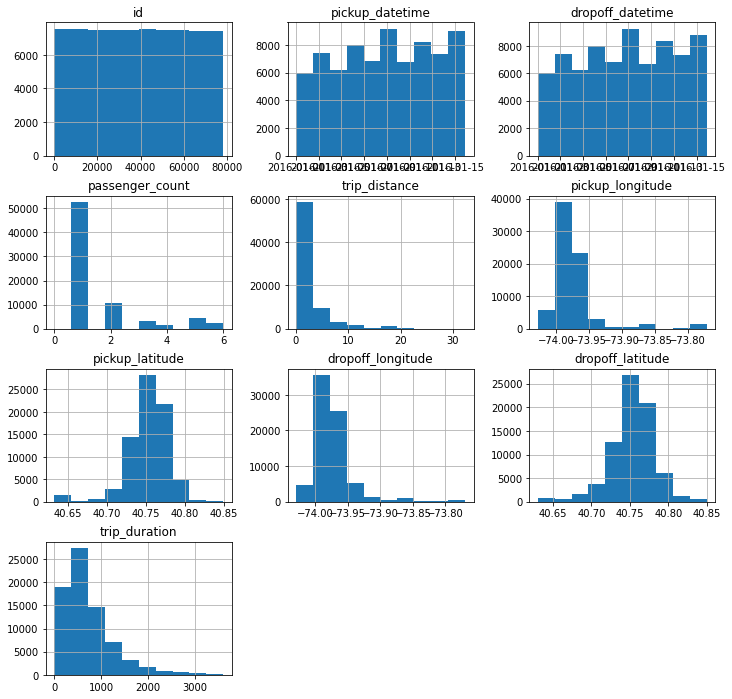

In [ ]:
trips.hist(figsize=(12,12))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


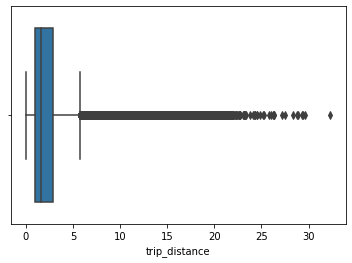

In [ ]:
sns.boxplot(trips['trip_distance'])
plt.show()

In [ ]:
trips[trips['trip_distance']>100]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,trip_duration,pickup_neighborhood,dropoff_neighborhood


In [ ]:
trips['trip_distance']=trips['trip_distance'].clip(trips['trip_distance'].min(),50)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


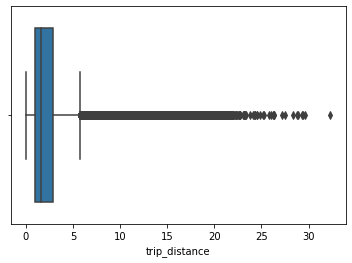

In [ ]:
sns.boxplot(trips['trip_distance'])
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


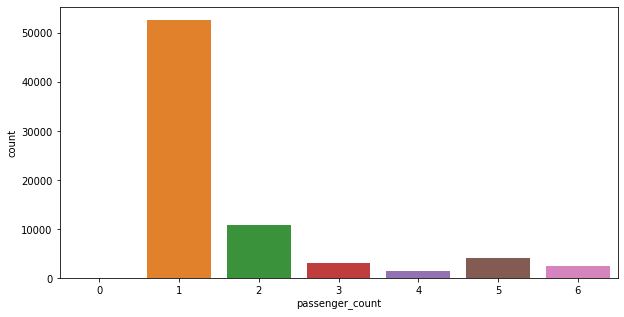

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(trips.passenger_count)
plt.show()


In [ ]:
trips.passenger_count.value_counts(normalize=True)

1    0.703857
2    0.144672
5    0.056520
3    0.040877
6    0.033677
4    0.020358
0    0.000040
Name: passenger_count, dtype: float64

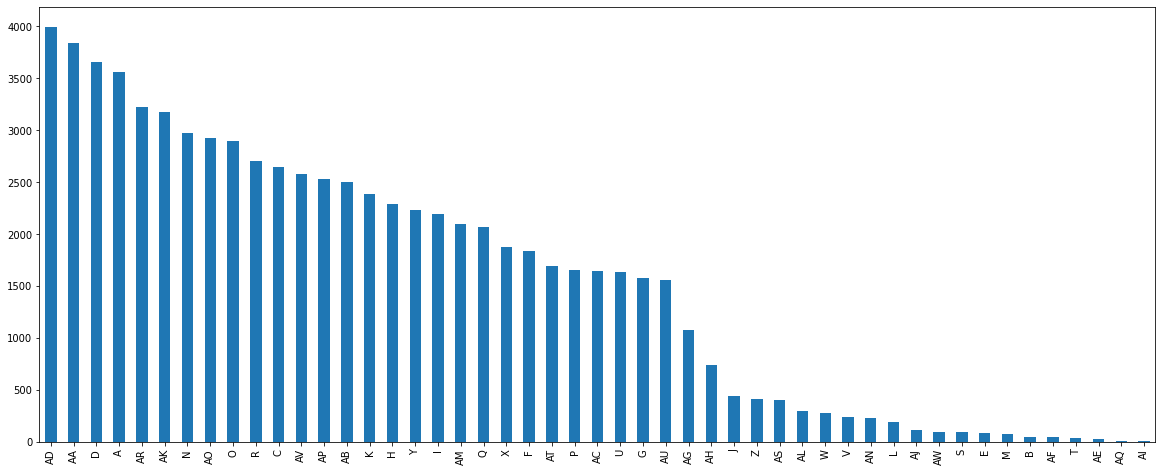

In [ ]:
trips.pickup_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,8))

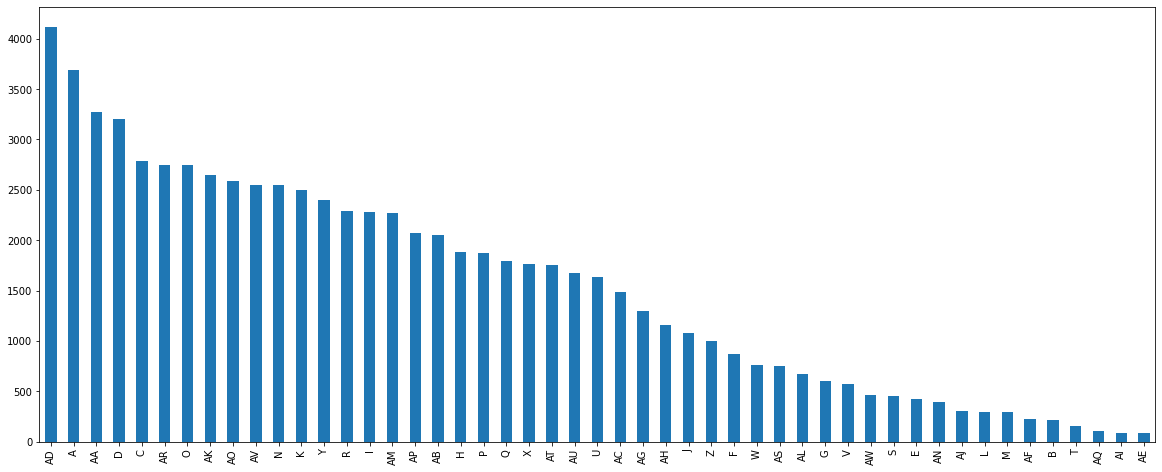

In [ ]:
trips.dropoff_neighborhood.value_counts().sort_values(ascending=False).plot(kind='bar' ,figsize=(20,8))

In [ ]:
pickup_neighborhoods.head()

,neighborhood_id,latitude,longitude
0,AH,40.804349,-73.961716
1,Z,40.715828,-73.954298
2,D,40.750179,-73.992557
3,AT,40.729670,-73.981693
4,AG,40.749843,-74.003458


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


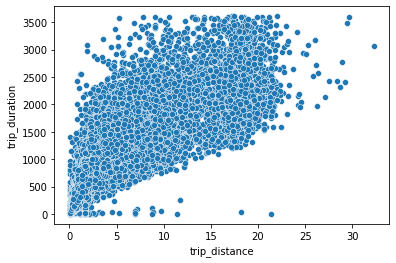

In [ ]:
sns.scatterplot(trips['trip_distance'],trips['trip_duration'])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


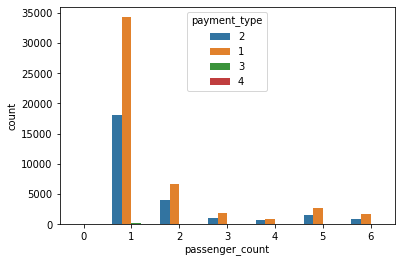

In [ ]:
sns.countplot(trips['passenger_count'],hue=trips['payment_type'])

In [ ]:
entities = {
        "trips": (trips, "id", 'pickup_datetime' ),
        "pickup_neighborhoods": (pickup_neighborhoods, "neighborhood_id"),
        "dropoff_neighborhoods": (dropoff_neighborhoods, "neighborhood_id"),
        }

relationships = [("pickup_neighborhoods", "neighborhood_id", "trips", "pickup_neighborhood"),
                 ("dropoff_neighborhoods", "neighborhood_id", "trips", "dropoff_neighborhood")]

In [ ]:
cutoff_time = trips[['id', 'pickup_datetime']]
cutoff_time = cutoff_time[cutoff_time['pickup_datetime'] > "2016-01-12"]
preview(cutoff_time, 10)


,id,pickup_datetime
54031,56311,2016-01-12 00:00:25
67921,70918,2016-01-14 16:35:11
67920,70917,2016-01-14 16:35:09
67919,70916,2016-01-14 16:34:50
67918,70915,2016-01-14 16:34:49
67917,70914,2016-01-14 16:34:46
67916,70913,2016-01-14 16:34:45
67915,70912,2016-01-14 16:34:26
67922,70919,2016-01-14 16:35:24
67914,70911,2016-01-14 16:34:21


In [ ]:
trans_primitives = [IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
print ("Number of features: %d" % len(features))
features

Number of features: 13


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [ ]:
def compute_features(features, cutoff_time):
    # shuffle so we don't see encoded features in the front or backs

    np.random.shuffle(features)
    feature_matrix = ft.calculate_feature_matrix(features,
                                                 cutoff_time=cutoff_time,
                                                 approximate='36d',
                                                 verbose=True,entities=entities, relationships=relationships)
    print("Finishing computing...")
    feature_matrix, features = ft.encode_features(feature_matrix, features,
                                                  to_encode=["pickup_neighborhood", "dropoff_neighborhood"],
                                                  include_unknown=False)
    return feature_matrix



In [ ]:
feature_matrix1 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [ ]:
preview(feature_matrix1, 5)

,dropoff_neighborhood = AD,dropoff_neighborhood = A,dropoff_neighborhood = AA,dropoff_neighborhood = D,dropoff_neighborhood = C,dropoff_neighborhood = AK,dropoff_neighborhood = AR,dropoff_neighborhood = AO,dropoff_neighborhood = O,dropoff_neighborhood = N,...,pickup_neighborhood = A,pickup_neighborhood = D,pickup_neighborhood = AK,pickup_neighborhood = N,pickup_neighborhood = AR,pickup_neighborhood = AO,pickup_neighborhood = O,pickup_neighborhood = R,passenger_count,IS_WEEKEND(dropoff_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,False
70918,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,1,False
70917,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,1,False
70916,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,2,False
70915,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,3,False


In [ ]:
feature_matrix1.shape

(20828, 31)

(array([  337.,  3190., 14588., 20909., 17379., 10089.,  4942.,  2080.,
          899.,   446.]),
 array([ 1.        ,  6.90416522, 12.80833044, 18.71249566, 24.61666088,
        30.5208261 , 36.42499133, 42.32915655, 48.23332177, 54.13748699,
        60.04165221]),
 <a list of 10 Patch objects>)

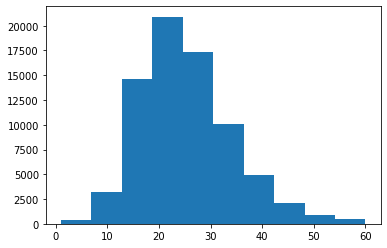

In [ ]:
plt.hist(np.sqrt(trips['trip_duration']))


(array([2.0000e+01, 3.9000e+01, 3.9000e+01, 1.1100e+02, 2.3600e+02,
        1.7590e+03, 1.2089e+04, 3.1012e+04, 2.4556e+04, 4.9980e+03]),
 array([0.        , 0.8190077 , 1.63801541, 2.45702311, 3.27603082,
        4.09503852, 4.91404623, 5.73305393, 6.55206164, 7.37106934,
        8.19007705]),
 <a list of 10 Patch objects>)

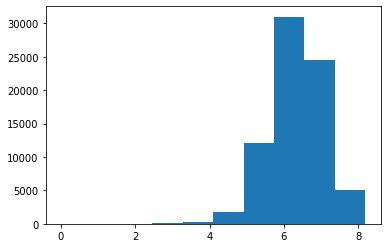

In [ ]:
plt.hist(np.log(trips['trip_duration']))

In [ ]:
X_train, y_train, X_test, y_test = get_train_test_fm(feature_matrix1,.75)
y_train = np.sqrt(y_train)
y_test = np.sqrt(y_test)

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((targets - predictions) ** 2).mean())

# MAE
def mae(predictions, targets):
    return np.mean(np.abs((targets - predictions)))


# Model Performance on test and train data
def model_pref(model, x_train, x_test, y_train,y_test):

    # Insample Prediction
    y_pred_train = model.predict(x_train)
    y_observed_train = y_train

    # Prediction on test data
    y_pred_test = model.predict(x_test)
    y_observed_test = y_test

    print(
        pd.DataFrame(
            {
                "Data": ["Train", "Test"],
                'RSquared':
                    [r2_score(y_observed_train,y_pred_train),
                    r2_score(y_observed_test,y_pred_test )
                    ],
                "RMSE": [
                    rmse(y_pred_train, y_observed_train),
                    rmse(y_pred_test, y_observed_test),
                ],
                "MAE": [
                    mae(y_pred_train, y_observed_train),
                    mae(y_pred_test, y_observed_test),
                ],
            }
        )
    )

In [ ]:
lr1=LinearRegression()


lr1.fit(X_train,y_train)

LinearRegression()

In [ ]:
model_pref(lr1, X_train, X_test,y_train,y_test)  

    Data  RSquared      RMSE       MAE
0  Train  0.584918  5.798660  4.506745
1   Test  0.612535  5.721635  4.451523


In [ ]:
dt=DecisionTreeRegressor()

dt.fit(X_train,y_train)

DecisionTreeRegressor()

In [ ]:
model_pref(dt, X_train, X_test,y_train,y_test) 

    Data  RSquared      RMSE       MAE
0  Train  0.982940  1.175588  0.362817
1   Test  0.543709  6.209046  4.734151


In [ ]:
dt_pruned=DecisionTreeRegressor(max_depth=3)

dt_pruned.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=3)

In [ ]:
model_pref(dt_pruned, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.700505  4.925559  3.762331
1   Test  0.730212  4.774360  3.680760


In [ ]:
rf=RandomForestRegressor(n_estimators=60,max_depth=7)

In [ ]:
rf.fit(X_train,y_train)

RandomForestRegressor(max_depth=7, n_estimators=60)

In [ ]:
model_pref(rf, X_train, X_test,y_train,y_test)

    Data  RSquared      RMSE       MAE
0  Train  0.764301  4.369583  3.365258
1   Test  0.767896  4.428380  3.433726


In [ ]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=[],
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)


In [ ]:
print ("Number of features: %d" % len(features))
features

Number of features: 23


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>]

In [ ]:
feature_matrix2 = compute_features(features, cutoff_time)

Elapsed: 00:00 | Progress: 100%|██████████
Finishing computing...


In [ ]:
feature_matrix2.shape

(20828, 41)

In [ ]:
feature_matrix2.head()

,vendor_id,DAY(pickup_datetime),MINUTE(pickup_datetime),dropoff_neighborhoods.latitude,payment_type,MONTH(dropoff_datetime),DAY(dropoff_datetime),WEEKDAY(dropoff_datetime),pickup_neighborhoods.longitude,dropoff_neighborhood = AD,...,pickup_neighborhood = AR,pickup_neighborhood = AO,pickup_neighborhood = O,pickup_neighborhood = R,MONTH(pickup_datetime),WEEKDAY(pickup_datetime),IS_WEEKEND(dropoff_datetime),HOUR(pickup_datetime),MINUTE(dropoff_datetime),IS_WEEKEND(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,2,12,0,40.721435,1,1,12,1,-73.987205,False,...,False,False,False,False,1,1,False,0,11,False
56312,2,12,2,40.715828,2,1,12,1,-73.785073,False,...,False,False,False,False,1,1,False,0,23,False
56313,1,12,2,40.818445,1,1,12,1,-73.948046,False,...,False,False,False,False,1,1,False,0,5,False
56314,2,12,2,40.742531,2,1,12,1,-73.991595,False,...,False,False,False,False,1,1,False,0,6,False
56315,2,12,3,40.818445,1,1,12,1,-73.969822,False,...,False,False,False,False,1,1,False,0,13,False


In [ ]:
X_train2, y_train2, X_test2, y_test2 = get_train_test_fm(feature_matrix2,.75)
y_train2 = np.sqrt(y_train2)
y_test2 = np.sqrt(y_test2)

In [ ]:
lr2=LinearRegression()

lr2.fit(X_train2,y_train2)

LinearRegression()

In [ ]:
model_pref(lr2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.954723  1.915135  1.385769
1   Test  0.952802  1.996941  1.412648


In [ ]:
dt2=DecisionTreeRegressor()

dt2.fit(X_train2,y_train2)

DecisionTreeRegressor()

In [ ]:
model_pref(dt2, X_train2, X_test2,y_train2,y_test2) 

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.000000  0.000000
1   Test  0.688383  5.131145  3.806026


In [ ]:
dt_pruned2=DecisionTreeRegressor(max_depth=4)

dt_pruned2.fit(X_train2,y_train2)

DecisionTreeRegressor(max_depth=4)

In [ ]:
model_pref(dt_pruned2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.734817  4.634826  3.509478
1   Test  0.763888  4.466450  3.392497


In [ ]:
rf2=RandomForestRegressor(n_estimators=60,max_depth=4)

rf2.fit(X_train2,y_train2)

RandomForestRegressor(max_depth=4, n_estimators=60)

In [ ]:
model_pref(rf2, X_train2, X_test2,y_train2,y_test2)  

    Data  RSquared      RMSE       MAE
0  Train  0.751285  4.488608  3.398188
1   Test  0.782378  4.288002  3.257250


In [ ]:
trans_primitives = [Minute, Hour, Day, Month, Weekday, IsWeekend]
aggregation_primitives = [Count, Sum, Mean, Median, Std, Max, Min]

features = ft.dfs(entities=entities,
                  relationships=relationships,
                  target_entity="trips",
                  trans_primitives=trans_primitives,
                  agg_primitives=aggregation_primitives,
                  ignore_variables={"trips": ["pickup_latitude", "pickup_longitude",
                                              "dropoff_latitude", "dropoff_longitude"]},
                  features_only=True)

In [ ]:
print ("Number of features: %d" % len(features))
features

Number of features: 61


[<Feature: vendor_id>,
 <Feature: passenger_count>,
 <Feature: trip_distance>,
 <Feature: payment_type>,
 <Feature: trip_duration>,
 <Feature: pickup_neighborhood>,
 <Feature: dropoff_neighborhood>,
 <Feature: DAY(dropoff_datetime)>,
 <Feature: DAY(pickup_datetime)>,
 <Feature: HOUR(dropoff_datetime)>,
 <Feature: HOUR(pickup_datetime)>,
 <Feature: IS_WEEKEND(dropoff_datetime)>,
 <Feature: IS_WEEKEND(pickup_datetime)>,
 <Feature: MINUTE(dropoff_datetime)>,
 <Feature: MINUTE(pickup_datetime)>,
 <Feature: MONTH(dropoff_datetime)>,
 <Feature: MONTH(pickup_datetime)>,
 <Feature: WEEKDAY(dropoff_datetime)>,
 <Feature: WEEKDAY(pickup_datetime)>,
 <Feature: pickup_neighborhoods.latitude>,
 <Feature: pickup_neighborhoods.longitude>,
 <Feature: dropoff_neighborhoods.latitude>,
 <Feature: dropoff_neighborhoods.longitude>,
 <Feature: pickup_neighborhoods.COUNT(trips)>,
 <Feature: pickup_neighborhoods.MAX(trips.passenger_count)>,
 <Feature: pickup_neighborhoods.MAX(trips.trip_distance)>,
 <Feature:

In [ ]:
feature_matrix3 = compute_features(features, cutoff_time)

Elapsed: 00:01 | Progress: 100%|██████████
Finishing computing...


In [ ]:
feature_matrix3.head()

,pickup_neighborhoods.STD(trips.trip_duration),pickup_neighborhoods.longitude,pickup_neighborhoods.MEDIAN(trips.trip_duration),pickup_neighborhoods.MEDIAN(trips.passenger_count),pickup_neighborhoods.STD(trips.trip_distance),MINUTE(pickup_datetime),dropoff_neighborhoods.MEAN(trips.trip_duration),dropoff_neighborhoods.MEDIAN(trips.trip_distance),pickup_neighborhoods.SUM(trips.passenger_count),pickup_neighborhoods.STD(trips.passenger_count),...,pickup_neighborhoods.MIN(trips.trip_duration),vendor_id,pickup_neighborhoods.MEAN(trips.passenger_count),IS_WEEKEND(pickup_datetime),pickup_neighborhoods.MAX(trips.trip_duration),passenger_count,dropoff_neighborhoods.STD(trips.trip_duration),dropoff_neighborhoods.MIN(trips.passenger_count),dropoff_neighborhoods.MEAN(trips.trip_distance),HOUR(pickup_datetime)
id,,,,,,,,,,,,,,,,,,,,,
56311,429.103720,-73.987205,682.5,1.0,2.536825,0,776.627978,1.88,2219.0,1.329779,...,5.0,2,1.709553,False,3292.0,1,495.023673,1.0,2.603682,0
56312,788.720284,-73.785073,2086.0,1.0,5.245664,2,1036.722148,4.05,2239.0,1.404130,...,1.0,2,1.791200,False,3604.0,1,612.281178,1.0,4.907705,0
56313,526.288091,-73.948046,513.0,1.0,2.943051,2,933.914230,4.11,390.0,1.427662,...,6.0,1,1.788991,False,3012.0,1,538.251916,1.0,4.865010,0
56314,425.565644,-73.991595,587.0,1.0,2.185131,2,570.183240,1.40,2838.0,1.301846,...,2.0,2,1.666471,False,3323.0,5,387.674630,1.0,2.019000,0
56315,417.894779,-73.969822,501.0,1.0,2.057303,3,933.914230,4.11,1897.0,1.270603,...,13.0,2,1.613095,False,2511.0,1,538.251916,1.0,4.865010,0


In [ ]:
X_train3, y_train3, X_test3, y_test3 = get_train_test_fm(feature_matrix3,.75)
y_train3 = np.sqrt(y_train3)
y_test3 = np.sqrt(y_test3)

In [ ]:
lr3=LinearRegression()

lr3.fit(X_train3,y_train3)

LinearRegression()

In [ ]:
model_pref(lr3, X_train3, X_test3,y_train3,y_test3) 

    Data  RSquared      RMSE       MAE
0  Train  0.956018  1.887543  1.363710
1   Test  0.954569  1.959201  1.381301


In [ ]:
dt3=DecisionTreeRegressor()

dt3.fit(X_train3,y_train3)

DecisionTreeRegressor()

In [ ]:
model_pref(dt3, X_train3, X_test3,y_train3,y_test3)  

    Data  RSquared      RMSE       MAE
0  Train  1.000000  0.000000  0.000000
1   Test  0.674072  5.247648  3.961222


In [ ]:
rf3=RandomForestRegressor(n_estimators=60,max_depth=4)

rf3.fit(X_train3,y_train3)

RandomForestRegressor(max_depth=4, n_estimators=60)

In [ ]:
model_pref(rf3, X_train3, X_test3,y_train3,y_test3) 

    Data  RSquared      RMSE       MAE
0  Train  0.751507  4.486609  3.395024
1   Test  0.782544  4.286372  3.256414


In [ ]:
y_pred = rf2.predict(X_test2)
y_pred = y_pred**2 # undo the sqrt we took earlier
y_pred[5:]

array([ 506.60286724,  389.47442021, 1181.27392512, ...,  588.29625525,
       1063.38324524,  884.61725741])

In [ ]:
feature_importances(rf2, feature_matrix2.drop(['trip_duration'],axis=1).columns, n=10)

1: Feature: trip_distance, 0.956
2: Feature: HOUR(dropoff_datetime), 0.036
3: Feature: HOUR(pickup_datetime), 0.007
4: Feature: payment_type, 0.001
5: Feature: pickup_neighborhoods.longitude, 0.000
6: Feature: dropoff_neighborhoods.longitude, 0.000
7: Feature: dropoff_neighborhoods.latitude, 0.000
8: Feature: vendor_id, 0.000
9: Feature: DAY(pickup_datetime), 0.000
10: Feature: MINUTE(pickup_datetime), 0.000
